In [27]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip /content/gdrive/MyDrive/planet.zip  -d /content/gdrive/MyDrive/Project/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_55.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_550.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5500.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5501.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5502.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5503.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5504.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5505.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5506.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5507.jpg  
  inflating: /content/gdrive/MyDrive/Project/data/planet/train-jpg/train_5508.jpg  
  inflating: /content/gdrive

In [29]:
#reading the labels
train_label = pd.read_csv('/content/gdrive/MyDrive/Project/data/planet/train_classes.csv')
sam_sub = pd.read_csv('/content/gdrive/MyDrive/Project/data/planet/sample_submission.csv')
train_label.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [30]:
#getting encoded labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#onehot=OneHotEncoder()
encoder = LabelEncoder()
#encoder.fit(train_label['tags'])
label_maps = pd.DataFrame()
label_maps['tags'] = ['agriculture', 'artisinal_mine', 'bare_ground','blooming','blow_down','clear','cloudy','conventional_mine','cultivation','habitation','haze', 'partly_cloudy','primary','road','selective_logging','slash_burn','water']
label_maps['map'] = encoder.fit_transform(label_maps['tags'])
label_maps

,tags,map
0,agriculture,0
1,artisinal_mine,1
2,bare_ground,2
3,blooming,3
4,blow_down,4
5,clear,5
6,cloudy,6
7,conventional_mine,7
8,cultivation,8
9,habitation,9


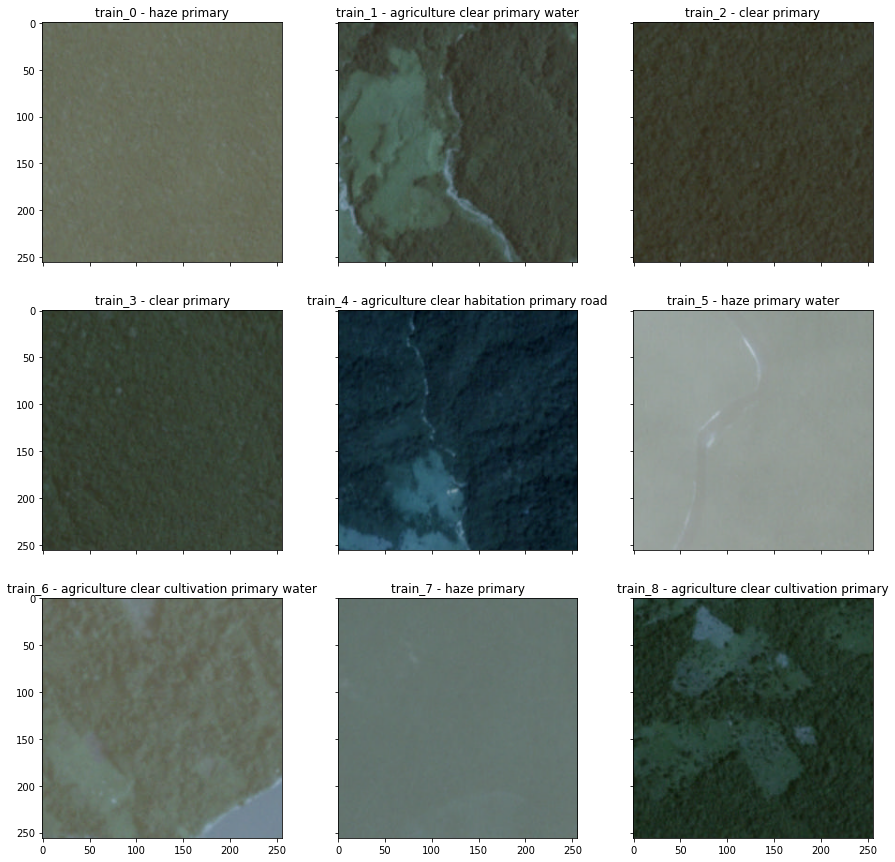

In [31]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15, 15))
i = 0
for f, tags in train_label[:9].values:
    img = cv2.imread('/content/gdrive/MyDrive/Project/data/planet/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(img)
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, tags))
  
    i += 1
    
plt.show()

In [32]:
#defining a dict of encoded labels
label_map = {'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [50]:
#loading the traing_images
X = []
Y = []
train_label = shuffle(train_label,random_state=0)
for image_name, tags in tqdm(train_label.values, miniters=400):
  arr = cv2.imread('/content/gdrive/MyDrive/Project/data/planet/train-jpg/train_0.jpg'.format(image_name), cv2.IMREAD_UNCHANGED)
  targets = np.zeros(17)
  for t in tags.split(' '):
    targets[label_map[t]] = 1
  arr = cv2.resize(arr, (64, 64))
  X.append(arr)
  Y.append(targets)

X = np.array(X, np.float16)/255.0

100%|██████████| 40479/40479 [02:13<00:00, 304.05it/s]


In [51]:
#splitting
from sklearn.model_selection import train_test_split

X = np.array(X)
Y = np.array(Y)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 1)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(32383, 64, 64, 3) (32383, 17) (8096, 64, 64, 3) (8096, 17)


In [35]:
#deleting uneccessary datas
import gc
del X, Y
gc.collect()

20374

In [36]:
import gc
gc.collect()

131

In [37]:

import numpy as np
from keras import backend as K
from sklearn.metrics import fbeta_score

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [13]:
# base model. Feel free to try out other architectures and ideas to improve fbeta score
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

#with tpu_strategy.scope():
model = keras.Sequential()
model.add(Conv2D(64, 5, 2, activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, 5, 2, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(17, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = [fbeta])
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 45, batch_size = 64)

Epoch 1/45
506/506 [==============================] - 99s 193ms/step - loss: 0.2614 - fbeta: 0.6044 - val_loss: 0.2587 - val_fbeta: 0.6066
Epoch 2/45
506/506 [==============================] - 93s 184ms/step - loss: 0.2572 - fbeta: 0.6046 - val_loss: 0.2576 - val_fbeta: 0.6066
Epoch 3/45
506/506 [==============================] - 91s 181ms/step - loss: 0.2570 - fbeta: 0.6045 - val_loss: 0.2553 - val_fbeta: 0.6066
Epoch 4/45
506/506 [==============================] - 93s 185ms/step - loss: 0.2567 - fbeta: 0.6046 - val_loss: 0.2554 - val_fbeta: 0.6066
Epoch 5/45
506/506 [==============================] - 103s 203ms/step - loss: 0.2566 - fbeta: 0.6046 - val_loss: 0.2554 - val_fbeta: 0.6066
Epoch 6/45
506/506 [==============================] - 142s 281ms/step - loss: 0.2563 - fbeta: 0.6045 - val_loss: 0.2558 - val_fbeta: 0.6066
Epoch 7/45
506/506 [==============================] - 118s 234ms/step - loss: 0.2562 - fbeta: 0.6047 - val_loss: 0.2555 - val_fbeta: 0.6066
Epoch 8/45
506/506 [====

In [38]:
import gc
gc.collect()

217

In [39]:
#with tpu_strategy.scope():
test_loss, test_accuracy = model.evaluate(x_val, y_val)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

253/253 [==============================] - 7s 26ms/step - loss: 0.2551 - fbeta: 0.6071
Test loss: 0.2550683319568634
Test accuracy: 0.6070707440376282


In [40]:
import gc
gc.collect()

948

In [41]:
model.evaluate(x_val, y_val)
print("train fscore: ", fbeta_score(y_train, np.round(model.predict(x_train)), 2,average = 'weighted'))
print("val fscore: ", fbeta_score(y_val, np.round(model.predict(x_val)), 2, average = 'weighted'))

253/253 [==============================] - 7s 26ms/step - loss: 0.2551 - fbeta: 0.6071
train fscore:  0.5429212436695063
val fscore:  0.5450117760518588


In [42]:
import gc
del x_train, y_train, x_val, y_val
gc.collect()

2400

In [43]:
#dividing my test_labels into two part for test-jpg and test-jpg-additional
test = sam_sub[0 : 40669]
files = sam_sub[40669 : ]

In [47]:
#with tpu_strategy.scope():   
test_img = []

for image_name, tags in tqdm(test.values, miniters=1000):
    arr = cv2.imread('/content/gdrive/MyDrive/Project/data/planet/train-jpg/train_0.jpg'.format(image_name))
    test_img.append(cv2.resize(arr, (64, 64)))

for image_name, tags in tqdm(files.values, miniters=1000):
    arr = cv2.imread('/content/gdrive/MyDrive/Project/data/planet/test-jpg/test_0.jpg'.format(image_name))
    test_img.append(cv2.resize(arr, (64, 64)))

test_img = np.array(test_img, np.float16)/255.0

100%|██████████| 20522/20522 [01:20<00:00, 255.63it/s]


In [45]:
import gc
gc.collect()

95

In [53]:
model.evaluate(x_val, y_val)
print("train fscore: ", fbeta_score(y_train, np.round(model.predict(x_train)), 2,average = 'weighted'))
print("val fscore: ", fbeta_score(y_val, np.round(model.predict(x_val)), 2, average = 'weighted'))

253/253 [==============================] - 6s 24ms/step - loss: 0.2577 - fbeta: 0.6046
train fscore:  0.5437680940800381
val fscore:  0.5416246961711986


In [54]:
#dividing my test_labels into two part for test-jpg and test-jpg-additional
test = sam_sub[0 : 40669]
files = sam_sub[40669 : ]

In [55]:
#with tpu_strategy.scope():   
test_img = []

for image_name, tags in tqdm(test.values, miniters=1000):
    arr = cv2.imread('/content/gdrive/MyDrive/Project/data/planet/test-jpg/test_0.jpg'.format(image_name))
    test_img.append(cv2.resize(arr, (64, 64)))

for image_name, tags in tqdm(files.values, miniters=1000):
    arr = cv2.imread('/content/gdrive/MyDrive/Project/data/planet/test-jpg/test_0.jpg'.format(image_name))
    test_img.append(cv2.resize(arr, (64, 64)))

test_img = np.array(test_img, np.float16)/255.0

100%|██████████| 20522/20522 [01:13<00:00, 280.00it/s]


In [56]:
import gc
gc.collect()

3034

In [57]:
#with tpu_strategy.scope():
yres = []
predictions = model.predict(test_img, batch_size = 64, verbose = 2)
yres.append(predictions)

957/957 - 36s


In [58]:
import gc
gc.collect()

1287

In [59]:
#converting my encoded labels back to it original form
sub = np.array(yres[0])
for i in range (1, len(yres)):
    sub += np.array(yres[i])
sub = pd.DataFrame(sub, columns = label_map)

In [60]:
sub

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829
1,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829
2,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829
3,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829
4,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61186,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829
61187,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829
61188,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829
61189,0.292883,0.007408,0.01737,0.008538,0.002408,0.699505,0.057853,0.002942,0.111373,0.093747,0.063155,0.174971,0.923546,0.200546,0.010167,0.005407,0.171829


In [62]:
#saving my final result into a csv file
preds = []
for i in tqdm(range(sub.shape[0]), miniters=1000):
    a = sub.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a= a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

sam_sub['tags'] = preds
sam_sub.to_csv('/content/gdrive/MyDrive/Project/submission_1.csv', index=False)

100%|██████████| 61191/61191 [02:22<00:00, 429.34it/s]


In [63]:
sam_sub

,image_name,tags
0,test_0,agriculture clear primary road
1,test_1,agriculture clear primary road
2,test_2,agriculture clear primary road
3,test_3,agriculture clear primary road
4,test_4,agriculture clear primary road
...,...,...
61186,file_9995,agriculture clear primary road
61187,file_9996,agriculture clear primary road
61188,file_9997,agriculture clear primary road
61189,file_9998,agriculture clear primary road
